## Variants of stochastic gradient-based optimization

In this assignment, we will implement Stochastic Gradient Optimization with different variants and try to find good hyperparameters for them. 

I will begin this notebook by setting the scene for what is to come by defining the data and the raw model that we will improve in the later stages. I will also use *MSE* as the loss function and its gradient.

### 1. Setting the scene

we begin like usual by just importing all of the dependencies and then defining the model parameters and values and then generating the 3D plot of the noisy data.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# verify everything is workinghe s

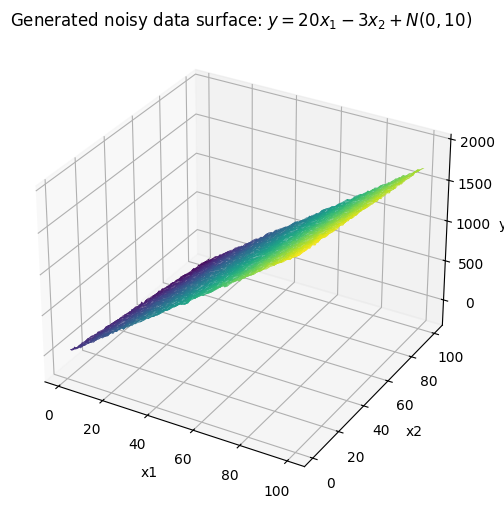

In [14]:
np.random.seed(1)

# Parameters
N = 100
a10 = 20
a20 = -3

# Generate all combinations of (x1, x2) from 1 to N
X1, X2 = np.meshgrid(np.arange(1, N+1), np.arange(1, N+1))
X1 = X1.flatten()
X2 = X2.flatten()
X = np.column_stack((X1, X2))

# Generate noisy targets: y = 20*x1 - 3*x2 + noise
R = np.random.normal(0, 10, size=N*N)
Y = a10 * X1 + a20 * X2 + R

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X[:, 0], X[:, 1], Y, cmap='viridis', linewidth=0.2)
ax.set_title("Generated noisy data surface: $y = 20x_1 - 3x_2 + N(0,10)$")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
plt.show()

we can then define the model, the loss function and its gradient.

In [15]:
def model(w, x):
    return np.dot(x, w)

# Define MSE loss function
def mse(w, model, X, Y):
    predictions = np.dot(X, w)
    return np.mean((Y - predictions)**2)

# %%
# Define gradient of MSE
def grad_mse(w, model, X, Y):
    N = len(Y)
    predictions = np.dot(X, w)
    error = predictions - Y
    grad = (2/N) * np.dot(X.T, error)
    return grad

# Initial weights with Glorot uniform initialization
in_dim = 2
out_dim = 1
limit = np.sqrt(6 / (in_dim + out_dim))
w0 = np.random.uniform(-limit, limit, size=(2,))
print("Initial weights (w0):", w0)

# Compute initial loss
initial_loss = mse(w0, model, X, Y)
print("Initial MSE loss:", initial_loss)

Initial weights (w0): [ 1.03260529 -1.32128993]
Initial MSE loss: 1064547.2959333684


We can then print the contour and how the vanilla gradient descent converges to our target point. I used the same parameters as the example.

I also plotted the total loss over our iterations to show that it decreases. We can also see that it converges to 0 just like the example.

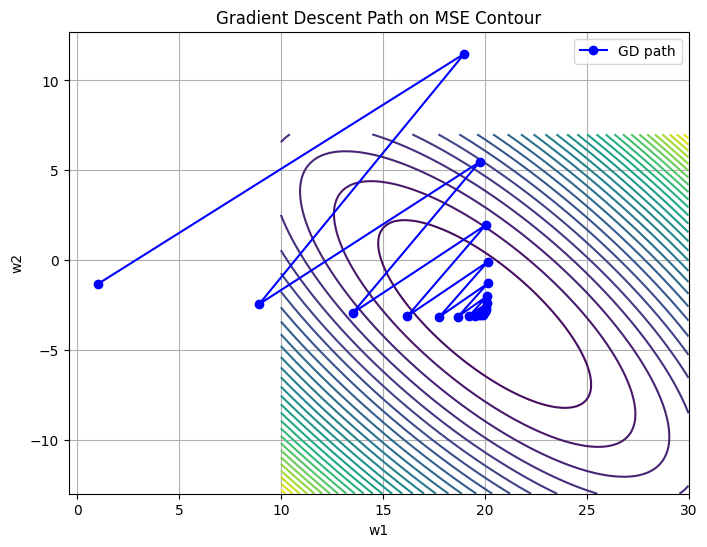

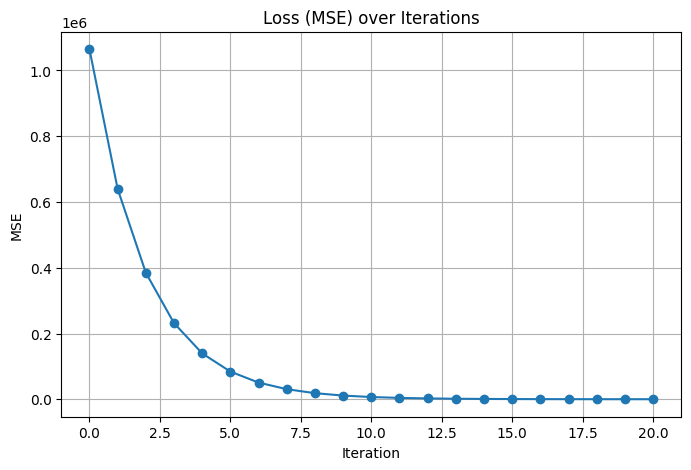

Final weights (w): [19.90656861 -3.02620454]
Final MSE loss: 144.64721257053787


In [16]:
# %%
# Gradient Descent optimizer (batch)
def grad_desc_mse(K, w_init, learning_rate, loss_func, grad_func, verbose=True):
    w = w_init.copy()
    history = [loss_func(w, model, X, Y)]
    trajectory = [w.copy()]
    for _ in range(K):
        grad = grad_func(w, model, X, Y)
        w -= learning_rate * grad
        trajectory.append(w.copy())
        history.append(loss_func(w, model, X, Y))
    return np.array(trajectory), history

# Set hyperparameters
K = 20
learning_rate = 0.00015

# Run optimization
trajectory, history = grad_desc_mse(K, w0, learning_rate, mse, grad_mse)

# %%
# Contour plot of MSE landscape
w1_vals = np.linspace(10, 30, 100)
w2_vals = np.linspace(-13, 7, 100)
W1, W2 = np.meshgrid(w1_vals, w2_vals)
Z = np.array([[mse(np.array([w1, w2]), model, X, Y) for w1 in w1_vals] for w2 in w2_vals])

plt.figure(figsize=(8,6))
cp = plt.contour(W1, W2, Z, levels=30, cmap='viridis')
plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', color='blue', label='GD path')
plt.title('Gradient Descent Path on MSE Contour')
plt.xlabel('w1')
plt.ylabel('w2')
plt.legend()
plt.grid(True)
plt.show()

# %%
# Plot MSE loss over iterations
plt.figure(figsize=(8,5))
plt.plot(range(len(history)), history, marker='o')
plt.title('Loss (MSE) over Iterations')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

# print convergence information
print("Final weights (w):", trajectory[-1])
print("Final MSE loss:", history[-1])

### 2. Stochastic gradient descent (SGD)

In [17]:
# SGD function (mini-batch stochastic gradient descent)
def stochastic_grad_desc_mse(K, w_init, learning_rate, loss_func, grad_func, N, batch_fraction=0.01, verbose=True):
    w = w_init.copy()
    history = [loss_func(w, model, X, Y)]
    trajectory = [w.copy()]
    batch_size = max(1, int(batch_fraction * N))

    for _ in range(K):
        rand_indices = np.random.choice(N, size=batch_size, replace=False)
        grad = grad_func(w, model, X[rand_indices], Y[rand_indices])
        old_w = w.copy()
        w -= learning_rate * grad
        trajectory.append(w.copy())
        history.append(loss_func(w, model, X, Y))

    return np.array(trajectory), history

# %%
# Define a version of grad_mse that accepts sampled data
def grad_mse_sampled(w, model, X_sample, Y_sample):
    N = len(Y_sample)
    predictions = np.dot(X_sample, w)
    error = predictions - Y_sample
    grad = (2/N) * np.dot(X_sample.T, error)
    return grad

# Set hyperparameters
K = 20
learning_rate = 0.00015

# Run SGD
trajectory_sgd, history_sgd = stochastic_grad_desc_mse(K, w0, learning_rate, mse, grad_mse_sampled, N=X.shape[0])


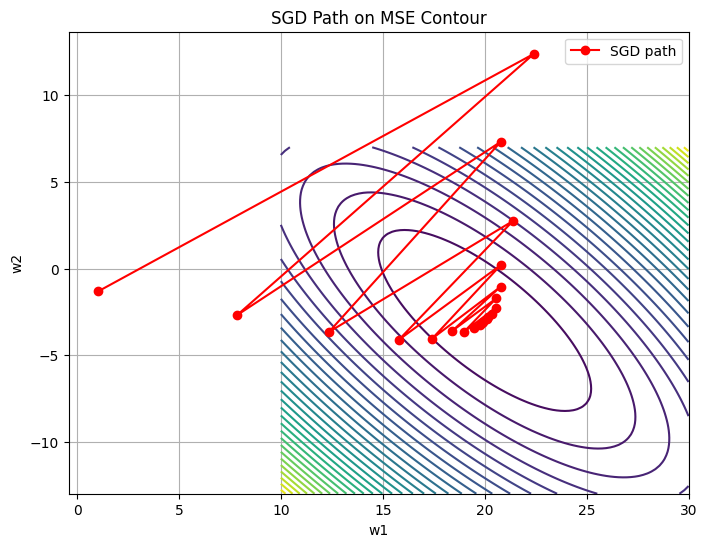

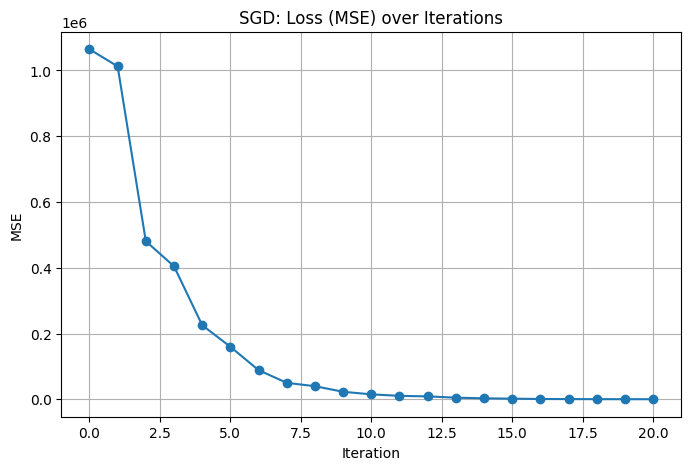

In [19]:
# %%
# Contour plot for SGD
w1_vals = np.linspace(10, 30, 100)
w2_vals = np.linspace(-13, 7, 100)
W1, W2 = np.meshgrid(w1_vals, w2_vals)
Z = np.array([[mse(np.array([w1, w2]), model, X, Y) for w1 in w1_vals] for w2 in w2_vals])

plt.figure(figsize=(8,6))
cp = plt.contour(W1, W2, Z, levels=30, cmap='viridis')
plt.plot(trajectory_sgd[:, 0], trajectory_sgd[:, 1], marker='o', color='red', label='SGD path')
plt.title('SGD Path on MSE Contour')
plt.xlabel('w1')
plt.ylabel('w2')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(len(history_sgd)), history_sgd, marker='o')
plt.title('SGD: Loss (MSE) over Iterations')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

### 3. SGD with accumulated squared gradient: RMSProphe

In [20]:
# %% [markdown]
# ## Step 3: RMSProp Optimizer
# RMSProp adapts learning rates using exponentially weighted average of squared gradients.

# %%
def rmsprop_mse(K, w_init, learning_rate, loss_func, grad_func, N, rho=0.9, batch_fraction=0.01, delta=1e-10, verbose=True):
    w = w_init.copy()
    history = [loss_func(w, model, X, Y)]
    trajectory = [w.copy()]
    r = np.zeros_like(w)
    batch_size = max(1, int(batch_fraction * N))

    for _ in range(K):
        rand_indices = np.random.choice(N, size=batch_size, replace=False)
        grad = grad_func(w, model, X[rand_indices], Y[rand_indices])
        r = rho * r + (1 - rho) * grad**2
        old_w = w.copy()
        w -= (learning_rate / (np.sqrt(r) + delta)) * grad
        trajectory.append(w.copy())
        history.append(loss_func(w, model, X, Y))

    return np.array(trajectory), history

# %% [markdown]
# ### Run RMSProp optimizer

# %%
# Set hyperparameters
K = 20
learning_rate = 1.0   # based on the notebook's final tested value
rho = 0.98            # final chosen decay rate

# Run RMSProp
trajectory_rms, history_rms = rmsprop_mse(K, w0, learning_rate, mse, grad_mse_sampled, N=X.shape[0], rho=rho)



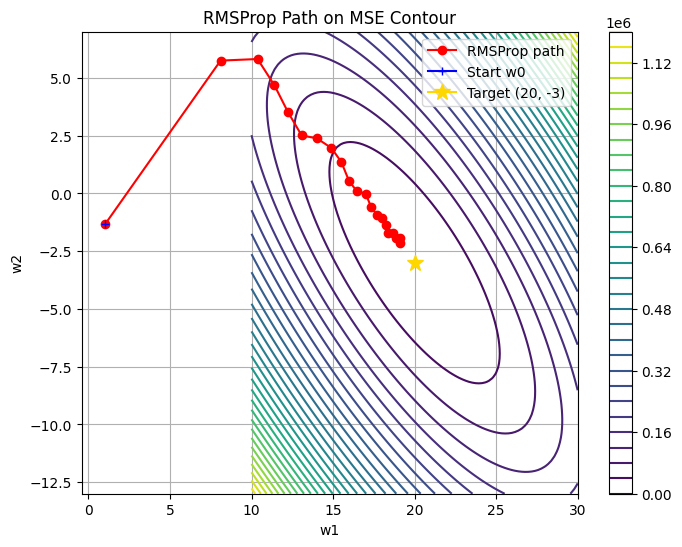

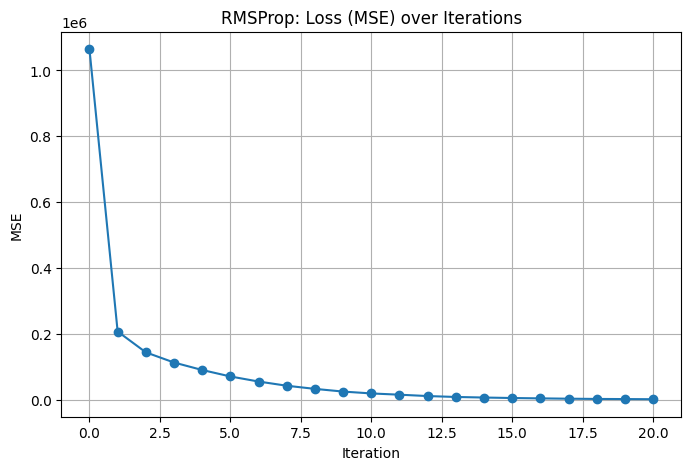

In [ ]:
# %% [markdown]
# ### Visualize RMSProp trajectory on the loss surface

# %%
plt.figure(figsize=(8,6))
cp = plt.contour(W1, W2, Z, levels=30, cmap='viridis')
plt.colorbar(cp)
plt.plot(trajectory_rms[:, 0], trajectory_rms[:, 1], marker='o', color='red', label='RMSProp path')
plt.plot(w0[0], w0[1], marker='+', color='blue', label='Start w0')
plt.plot(20, -3, marker='*', color='gold', label='Target (20, -3)', markersize=12)
plt.title('RMSProp Path on MSE Contour')
plt.xlabel('w1')
plt.ylabel('w2')
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]
# ### Plot the MSE loss over RMSProp iterations

# %%
plt.figure(figsize=(8,5))
plt.plot(range(len(history_rms)), history_rms, marker='o')
plt.title('RMSProp: Loss (MSE) over Iterations')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

### 4. SGD with accumulated squared gradient: ADAM

In [23]:
# %% [markdown]
# ## Step 4: ADAM Optimizer
# ADAM combines momentum (first moment) and RMSProp (second moment) with bias correction.

# %%
def adam_mse(K, w_init, learning_rate, loss_func, grad_func, N, rho1=0.9, rho2=0.999, batch_fraction=0.01, delta=1e-10, verbose=True):
    w = w_init.copy()
    history = [loss_func(w, model, X, Y)]
    trajectory = [w.copy()]
    s = np.zeros_like(w)  # First moment (momentum)
    r = np.zeros_like(w)  # Second moment (RMS)
    t = 0
    batch_size = max(1, int(batch_fraction * N))

    for _ in range(K):
        t += 1
        rand_indices = np.random.choice(N, size=batch_size, replace=False)
        grad = grad_func(w, model, X[rand_indices], Y[rand_indices])

        s = rho1 * s + (1 - rho1) * grad
        r = rho2 * r + (1 - rho2) * grad**2

        s_hat = s / (1 - rho1**t)
        r_hat = r / (1 - rho2**t)

        old_w = w.copy()
        w -= (learning_rate * s_hat) / (np.sqrt(r_hat) + delta)

        trajectory.append(w.copy())
        history.append(loss_func(w, model, X, Y))

    return np.array(trajectory), history


# %% [markdown]
# ### Run ADAM optimizer

# %%
# Set hyperparameters (from the notebook's tuning)
K = 100
learning_rate = 0.75
rho1 = 0.9
rho2 = 0.999

# Run ADAM
trajectory_adam, history_adam = adam_mse(K, w0, learning_rate, mse, grad_mse_sampled, N=X.shape[0], rho1=rho1, rho2=rho2)


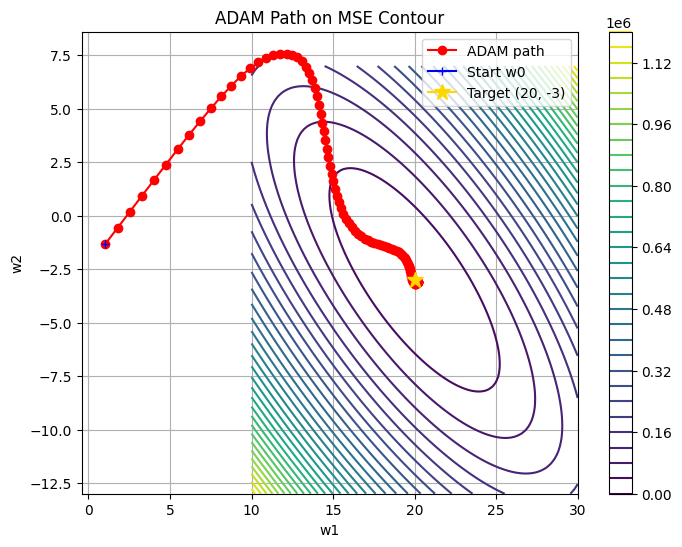

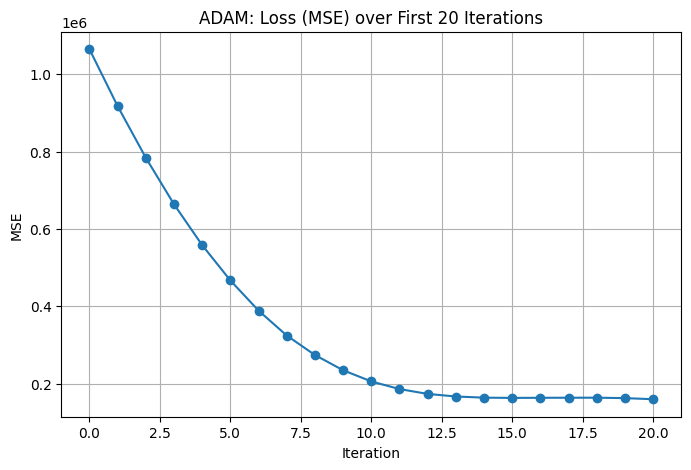

In [24]:
# %% [markdown]
# ### Visualize ADAM trajectory on the loss surface

# %%
plt.figure(figsize=(8,6))
cp = plt.contour(W1, W2, Z, levels=30, cmap='viridis')
plt.colorbar(cp)
plt.plot(trajectory_adam[:, 0], trajectory_adam[:, 1], marker='o', color='red', label='ADAM path')
plt.plot(w0[0], w0[1], marker='+', color='blue', label='Start w0')
plt.plot(20, -3, marker='*', color='gold', label='Target (20, -3)', markersize=12)
plt.title('ADAM Path on MSE Contour')
plt.xlabel('w1')
plt.ylabel('w2')
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]
# ### Plot the MSE loss over ADAM iterations

# %%
# Only show first 20 steps as in the MATLAB notebook
plt.figure(figsize=(8,5))
plt.plot(range(21), history_adam[:21], marker='o')
plt.title('ADAM: Loss (MSE) over First 20 Iterations')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

